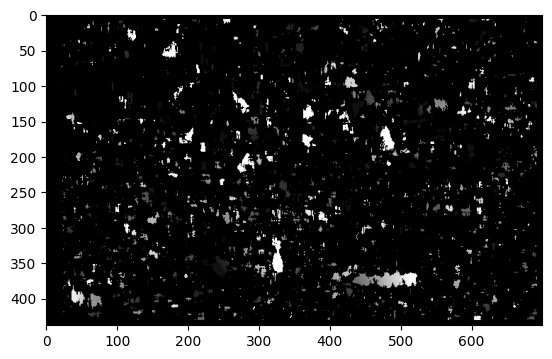

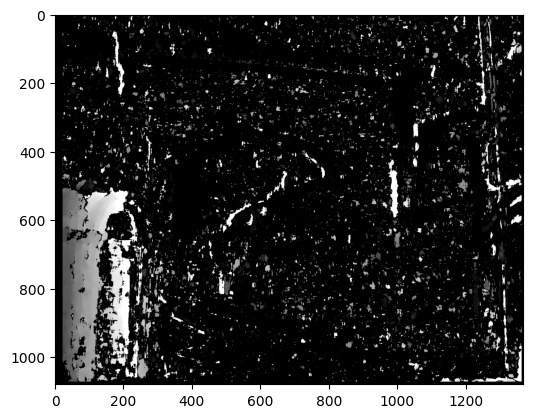

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt


imgR = cv.imread('stereopair_right.jpg', 0)
imgL = cv.imread('stereopair_left.jpg', 0)
imgR2 = cv.imread('stereopair_right2.jpg', 0)
imgR2 = cv.resize(imgR2, (1368, 1080))
imgL2 = cv.imread('stereopair_left2.jpg', 0)

# Создание объекта StereoBM
stereo = cv.StereoBM.create(
    numDisparities=16,
    blockSize=15
)

# Вычисление несоответствия
disparity = stereo.compute(imgL, imgR)
disparity2 = stereo.compute(imgL2, imgR2)

plt.imshow(disparity, 'gray')
plt.show()
plt.imshow(disparity2, 'gray')
plt.show()

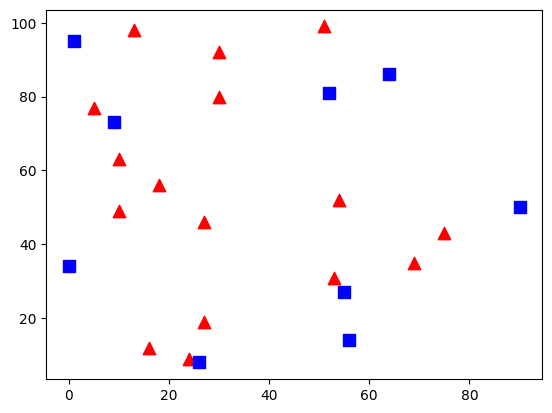

In [2]:
import numpy as np


# Feature set containing (x,y) values of 25 known/training data
trainData = np.random.randint(0, 100, (25, 2)).astype(np.float32)

# Labels each one either Red or Blue with numbers 0 and 1
responses = np.random.randint(0, 2, (25, 1)).astype(np.float32)

# Take Red families and plot them
red = trainData[responses.ravel() == 0]
plt.scatter(red[:, 0], red[:, 1], 80, 'r', '^')

# Take Blue families and plot them
blue = trainData[responses.ravel() == 1]
plt.scatter(blue[:, 0], blue[:, 1], 80, 'b', 's')

plt.show()

results:  [[1.]
 [1.]
 [1.]
 [1.]
 [1.]] 

neighbours:  [[1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]
 [1. 1. 0.]
 [1. 1. 0.]] 

distances:  [[ 25.  65. 144.]
 [ 64. 260. 401.]
 [ 65. 116. 137.]
 [148. 288. 349.]
 [  5.  32.  41.]]


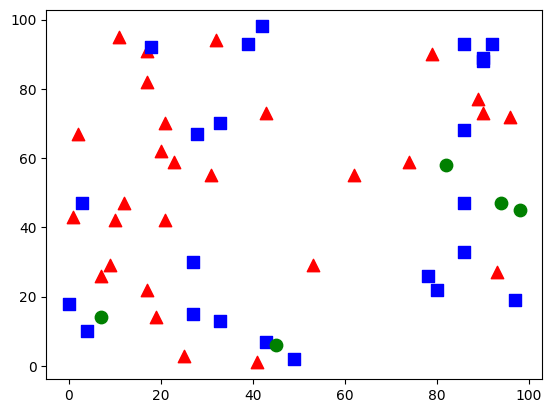

In [3]:
trainData = np.random.randint(0, 100, (51, 2)).astype(np.float32)
responses = np.random.randint(0, 2, (51, 1)).astype(np.float32)

red = trainData[responses.ravel() == 0]
plt.scatter(red[:, 0], red[:, 1], 80, 'r', '^')
blue = trainData[responses.ravel() == 1]
plt.scatter(blue[:, 0], blue[:, 1], 80, 'b', 's')

newcomer = np.random.randint(0, 100, (5, 2)).astype(np.float32)
plt.scatter(newcomer[:, 0], newcomer[:, 1], 80, 'g', 'o')

knn = cv.ml.KNearest.create()
knn.train(trainData, cv.ml.ROW_SAMPLE, responses)
ret, results, neighbours, dist = knn.findNearest(newcomer, 3)

print ("results: ", results, "\n")
print ("neighbours: ", neighbours, "\n")
print ("distances: ", dist)

plt.show()

In [4]:
img = cv.imread('digits.png')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Now we split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row, 100) for row in np.vsplit(gray, 50)]

# Make it into a Numpy array: its size will be (50,100,20,20)
x = np.array(cells)

# Now we prepare the training data and test data
train = x[:, :50].reshape(-1, 400).astype(np.float32) # Size = (2500,400)
test = x[:, 50:100].reshape(-1, 400).astype(np.float32) # Size = (2500,400)

# Create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k, 250)[:, np.newaxis]

# Save the data
np.savez('knn_data.npz',train=train, train_labels=train_labels)

In [5]:
# Now load the data
with np.load('knn_data.npz') as data:
    print(data.files)
    train = data['train']
    train_labels = data['train_labels']

test_labels = train_labels.copy()

# Initiate kNN, train it on the training data, then test it with the test data with k=1
knn = cv.ml.KNearest.create()
knn.train(train, cv.ml.ROW_SAMPLE, train_labels)
ret,result,neighbours,dist = knn.findNearest(test, k=5)

# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
matches = result == test_labels
correct = np.count_nonzero(matches)
accuracy = correct * 100.0 / result.size
print(accuracy)

['train', 'train_labels']
91.76


In [6]:
# Load the data and convert the letters to numbers
data= np.loadtxt(
    'letter-recognition.data',
    dtype='float32',
    delimiter=',',
    converters={0: lambda ch: ord(ch) - ord('A')}
)

# Split the dataset in two, with 10000 samples each for training and test sets
train, test = np.vsplit(data, 2)

# Split trainData and testData into features and responses
responses, trainData = np.hsplit(train, [1])
labels, testData = np.hsplit(test, [1])

# Initiate the kNN, classify, measure accuracy
knn = cv.ml.KNearest.create()
knn.train(trainData, cv.ml.ROW_SAMPLE, responses)

ret, result, neighbours, dist = knn.findNearest(testData, k=3)
correct = np.count_nonzero(result == labels)
accuracy = correct * 100.0 / 10000
print(accuracy)

93.61


In [7]:
SZ=20
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR

def deskew(img):
    m = cv.moments(img)

    if abs(m['mu02']) < 1e-2:
        return img.copy()
    
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SZ * skew], [0, 1, 0]])
    img = cv.warpAffine(img, M, (SZ, SZ), flags=affine_flags)

    return img


def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n * ang / (2 * np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10, :10], bins[10:, :10], bins[:10, 10:], bins[10:, 10:]
    mag_cells = mag[:10, :10], mag[10:, :10], mag[:10, 10:], mag[10:, 10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector

    return hist

img = cv.imread('digits.png', 0)

if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

cells = [np.hsplit(row, 100) for row in np.vsplit(img, 50)]
# First half is trainData, remaining is testData
train_cells = [i[:50] for i in cells]
test_cells = [i[50:] for i in cells]

deskewed = [list(map(deskew, row)) for row in train_cells]
hogdata = [list(map(hog, row)) for row in deskewed]

trainData = np.float32(hogdata).reshape(-1, 64)
responses = np.repeat(np.arange(10), 250)[:, np.newaxis]

svm = cv.ml.SVM.create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)
svm.train(trainData, cv.ml.ROW_SAMPLE, responses)
svm.save('svm_data.dat')

deskewed = [list(map(deskew, row)) for row in test_cells]
hogdata = [list(map(hog, row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1, bin_n * 4)
result = svm.predict(testData)[1]

mask = result == responses
correct = np.count_nonzero(mask)
print(correct * 100.0 / result.size)

93.8


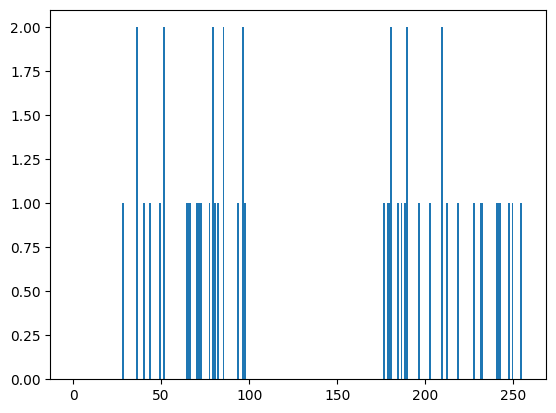

In [8]:
x = np.random.randint(25,100,25)
y = np.random.randint(175,255,25)
z = np.hstack((x,y))
z = z.reshape((50,1))
z = np.float32(z)

plt.hist(z,256,[0,256])
plt.show()

In [9]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Set flags (Just to avoid line break in the code)
flags = cv.KMEANS_RANDOM_CENTERS
# Apply KMeans
compactness,labels,centers = cv.kmeans(z, 2, None, criteria, 10, flags)

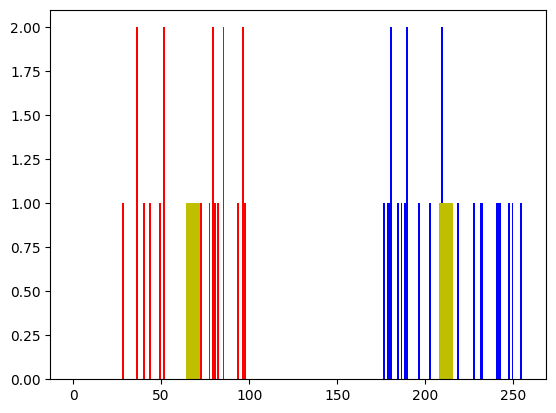

In [10]:
A = z[labels==0]
B = z[labels==1]

# Now plot 'A' in red, 'B' in blue, 'centers' in yellow
plt.hist(A, 256, [0, 256], color='r')
plt.hist(B, 256, [0, 256], color='b')
plt.hist(centers, 32, [0, 256], color='y')
plt.show()

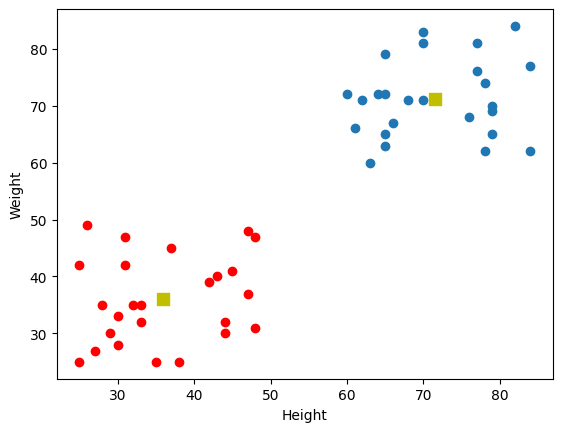

In [11]:
X = np.random.randint(25, 50, (25, 2))
Y = np.random.randint(60, 85, (25, 2))
Z = np.vstack((X, Y))

# convert to np.float32
Z = np.float32(Z)

# define criteria and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the flatten()
A = Z[label.ravel() == 0]
B = Z[label.ravel() == 1]

# Plot the data
plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c='r')
plt.scatter(center[:, 0], center[:, 1], s=80, c='y', marker='s')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

In [15]:
image = cv.imread('stereopair_left.jpg')
cv.imshow('Original', image)
(h, w) = image.shape[:2]

# Преобразование изображения в массив пикселей
pixels = image.reshape((-1, 3))

# Количество цветов после квантования
num_clusters = [4, 8]

for num in num_clusters:
    # Применение алгоритма K-средних
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(
        np.float32(pixels),
        num,
        None,
        criteria,
        10,
        cv.KMEANS_RANDOM_CENTERS
    )

    # Преобразование центроидов в целочисленные значения
    centers = np.uint8(centers)

    # Замена каждого пикселя на цвет ближайшего центроида
    quantized_image = centers[labels.flatten()]
    quantized_image = quantized_image.reshape((h, w, 3))

    # Сохранение и отображение результирующего изображения
    cv.imwrite(f'quantized_image_{num}.jpg', quantized_image)
    cv.imshow(f'Quantized Image {num}', quantized_image)
cv.waitKey(0)
cv.destroyAllWindows()
